# Домашнее задание 6: классификация текстов

В этом домашнем задании вам предстоит построить классификатор текстов!

Данные мы будем использовать из Kaggle соревнования: https://www.kaggle.com/competitions/nlp-getting-started/data 


Оттуда надо скачать файл train.csv. На обучающую и тестовую выборки его поделим кодом ниже, менять его не надо!

Мы будем работать с датасетом постов из твиттера. Нам предстоит решать задачу бинарной классификации - определять содержатся ли в твитте информация о настоящей катастрофе/инциденте или нет.

In [1]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [2]:
data = pd.read_csv('train.csv')

In [3]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, random_state=42)

## Задание 1 (0.5 балла)

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [5]:
data.isnull().any() # выводим информацию о пропусках, как видим, они присутствуют

id          False
keyword      True
location     True
text        False
target      False
dtype: bool

In [6]:
train_1 = train.fillna(' ') # заменяем пропуски в train на пустое поле
train_1.isnull().sum().sum()

0

In [7]:
test = test.fillna(' ') # заменяем пропуски в test на пустое поле
test.isnull().sum().sum()

0

## Задание 2 (1 балл)
Давайте немного посмотрим на наши данные. Визуализируйте (где явно просят) или выведете информацию о следующем:

1. Какое распределение классов в обучающей выборке?


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

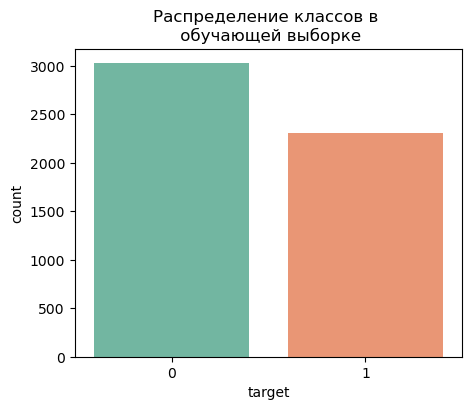

In [9]:
plt.figure(figsize=(5, 4))
sns.countplot(x = 'target', data=train, palette = 'Set2').set(title='Распределение классов в \n обучающей выборке')
plt.show()

2. Посмотрите на колонку "keyword" - возьмите 10 наиболее встречающихся значений, постройте ступенчатую диаграмму распределения классов в зависимости от значения keyword, сделайте выводы.

In [10]:
popular_keywords = train['keyword'].value_counts()[1:11].index.tolist()
popular_keywords

['siren',
 'wreckage',
 'fatalities',
 'deluge',
 'twister',
 'fatality',
 'harm',
 'emergency',
 'nuclear%20reactor',
 'derail']

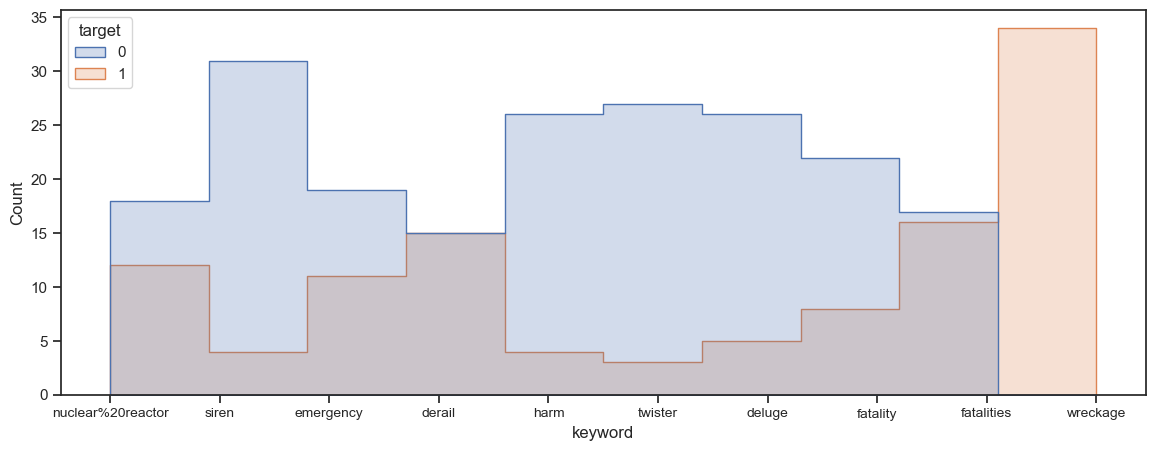

In [11]:
sns.set(style = 'ticks', rc={"figure.figsize":(14, 5),'xtick.labelsize': 10})
g = sns.histplot(data = train[train['keyword'].isin(popular_keywords)], x="keyword", hue = 'target', fill = True, 
             multiple = 'layer', discrete = False, element = 'step')
sns.move_legend(g, "upper left")

plt.show()

**Выводы**: наблюдаем сильный перевес *нулевого* ("0") класса для слов *siren, emergency, harm, twister, deluge, fatality*. Противоположная ситуация наблюдается только для слова *wreckage* - все твиты с данным словом относятся к *первому* ("1") классу. Для остальных *keywords* распределение классов приблизительно одинаково.

## Задание 3 (0.5 балла) 

В этом задании предлагается объединить все три текстовых столбца в один (просто сконкатенировать cтроки) и убрать столбец с индексом.

In [12]:
train_1.loc[[6590, 7122, 2769]]

,id,keyword,location,text,target
6590,9436,survivors,"Marietta, GA",Stemming from my #Cubs talk- the team rosters ...,1
7122,10203,violent%20storm,,If you were the NWS wth a rotating storm w/ a ...,1
2769,3980,devastation,Atlanta g.a.,http://t.co/Gxgm1T3W0J From Devastation to Ela...,0


In [13]:
train_new = pd.DataFrame({'text': train_1['keyword'] + ' ' + train_1['location'] + ' ' + train_1['text'], 'target' : train_1['target']})

In [14]:
train_new.loc[[6590, 7122, 2769]]

,text,target
6590,"survivors Marietta, GA Stemming from my #Cubs ...",1
7122,violent%20storm If you were the NWS wth a ro...,1
2769,devastation Atlanta g.a. http://t.co/Gxgm1T3W0...,0


In [15]:
test_new = pd.DataFrame({'text': test['keyword'] + ' ' + test['location'] + ' ' + test['text'], 'target' : test['target']})
# проделаем то же самое для тестовой выборки

## Задание 4 (0.5 балла)

Далее мы будем пока работать только с train частью.

1. Предобработайте данные (train часть) с помощью CountVectorizer.
2. Какого размера получилась матрица?


In [16]:
from sklearn.feature_extraction.text import CountVectorizer
cnt_vec = CountVectorizer()

M = cnt_vec.fit_transform(train_new['text'])

In [17]:
M

<5329x18455 sparse matrix of type '<class 'numpy.int64'>'
	with 86671 stored elements in Compressed Sparse Row format>

Получили sparse matrix - разреженную матрицу (содержит много нулей). 

Размер: 5329х18455

Можем преобразовать в np.array при помощи M.toarray()

## Задание 5 (1 балл)

В предыдущем пункте у вас должна была получиться достаточно большая матрица.
Если вы взгляните на текст, то увидете, что там есть множество специальных символов, ссылок и прочего мусора.

Давайте также посмотрим на словарь, который получился в результате построения CountVectorizer, его можно найти в поле vocabulary_ инстанса этого класса. Давайте напишем функцию, которая печает ответы на следующие вопросы:

1. Найдите в этом словаре все слова, которые содержат цифры. Сколько таких слов нашлось?

2. Найдите все слова, которые содержат символы пунктуации. Сколько таких слов нашлось? 

3. Сколько хэштегов (токен начинается на #) и упоминаний (токен начинается на @) осталось в словаре?

In [18]:
from string import punctuation

In [19]:
def contains_digit(s: str) -> bool:
    # Проверка, содержит ли слово цифры
    for i in s:
        if i.isnumeric():
            return True
    else:
        return False
        

def contains_punctuation(s: str) -> bool:
    # Проверка, содержит ли слово пунктуацию
    return len(set(punctuation) & set(s)) != 0

def is_hashtag(s: str) -> bool:
    # Проверка, является ли слово хэштегом
    return s.startswith('#')

def is_mention(s: str) -> bool:
    # Проверка, является ли слово упоминанием
    return s.startswith('@')

def investigate_vocabulary(vocabulary):
    
    print('With digit:      ', sum([contains_digit(i) for i in vocabulary.keys()])
          )
    print('With punctuation:', sum([contains_punctuation(i) for i in vocabulary.keys()])
          )
    print('Hashtags:        ', sum([is_hashtag(i) for i in vocabulary.keys()])
          )
    print('Mentions:        ', sum([is_mention(i) for i in vocabulary.keys()])
          )



In [20]:
dummy_vocab = {'th1nk' : 0,
               'think333' : 1,
               'think.' : 2,
               'th!nk' : 3,
               'th...nk' : 4,
               '#think' : 5,
               '@think' : 6,
               '@thinking':7,
               '@nothink' : 8,
               'think' : 9}
investigate_vocabulary(dummy_vocab)

With digit:       2
With punctuation: 7
Hashtags:         1
Mentions:         3


In [21]:
investigate_vocabulary(cnt_vec.vocabulary_)

With digit:       3815
With punctuation: 315
Hashtags:         0
Mentions:         0


## Задание 6 (0.5 балла)

Вспомним, что на семинаре по текстам мы узнали, что в nltk есть специальный токенизатор для текстов - TweetTokenizer. Попробуем применить CountVectorizer с этим токенизатором. Ответьте на все вопросы из предыдущего пункта для TweetTokenizer и сравните результаты.

In [22]:
from nltk.tokenize import TweetTokenizer

In [23]:
tw = TweetTokenizer()
cnt_vec2 = CountVectorizer(tokenizer = tw.tokenize)
cnt_vec2.fit_transform(train_new['text'])

<5329x19670 sparse matrix of type '<class 'numpy.int64'>'
	with 94563 stored elements in Compressed Sparse Row format>

In [24]:
investigate_vocabulary(cnt_vec2.vocabulary_)

With digit:       3940
With punctuation: 7338
Hashtags:         1470
Mentions:         1679


**Сравнение:** можем заметить, что токенизатор, предназначенный для работы с твитами, подсчитал гораздо большее количество хэштегов, упоминаний, символов пунктуации и цифр. В целом результат достаточно закономерен - токенайзер отделил слова и различные символы друг от друга, в связи с чем их число кратно возросло.

## Задание 7 (2 балла)

В scikit-learn мы можем оценивать процесс подсчета матрицы через CountVectorizer. У CountVectorizer, как и у других наследников \_VectorizerMixin, есть аргумент tokenizer и preprocessor. preprocessor применится в самом начале к каждой строке вашего датасета, tokenizer же должен принять строку и вернуть токены.
Давайте напишем кастомный токенайзер, которые сделает все, что нам нужно: 

0. Приведет все буквы к нижнему регистру
1. Разобьет текст на токены с помощью TweetTokenizer из пакета nltk
2. Удалит все токены содержащие не латинские буквы, кроме смайликов (будем считать ими токены содержащие только пунктуацию и, как минимум, одну скобочку) и хэштегов, которые после начальной # содержат только латинские буквы.
3. Удалит все токены, которые перечислены в nltk.corpus.stopwords.words('english')
4. Проведет стемминг с помощью SnowballStemmer



In [25]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

In [26]:
import re

In [27]:
def contains_only_latin_letters(s: str) -> bool:
    # Проверка, содержит ли слово только латинские буквы
    prog = re.compile('[A-Za-z]+')
    if len(prog.findall(s)) !=0:
        return prog.findall(s)[0] == s

def is_emoji(s: str) -> bool:
    punct_symbols = set(punctuation)
    brackets = set('()')

    only_punct = all([symbol in punct_symbols for symbol in s])
    had_bracket = any([symbol in brackets for symbol in s])

    return only_punct and had_bracket

def is_hashtag(s: str) -> bool:
    if s[0] == '#' and contains_only_latin_letters(s[1:]):
        return True
    else:
        return False

def custom_tokenizer(s: str) -> List[str]:    
    tw = TweetTokenizer()
    stemmer = SnowballStemmer('english')
    s_lower = tw.tokenize(s.lower())
    res = []
    for j in s_lower:
        if j not in stopwords.words('english'):
            if contains_only_latin_letters(j):
                res.append(j)
            elif is_emoji(j) or is_hashtag(j):
                res.append(j)
    return [stemmer.stem(i) for i in res]
  

In [28]:
custom_tokenizer('She LOVES painting :-) #art')

['love', 'paint', ':-)', '#art']

Продемонстрируйте работу вашей функции на первых десяти текстах в обучающей выборке.

In [29]:
for i in range(10):
    print(custom_tokenizer(str(train_new.loc[[train_new.index[i]]]['text'])))

['bridg', 'ash', 'australia', 'name', 'text', 'dtype', 'object']
['hail', 'carol', 'stream', 'illinoi', 'great', 'michigan', 'tec', 'name', 'text', 'dtype', 'object']
['polic', 'houston', 'cnn', 'tennesse', 'movi', 'theater', 'name', 'text', 'dtype', 'object']
['riot', 'still', 'riot', 'coupl', 'hour', 'l', 'name', 'text', 'dtype', 'object']
['wound', 'lake', 'highland', 'crack', 'path', 'name', 'text', 'dtype', 'object']
['airplan', 'somewher', 'expert', 'name', 'text', 'dtype', 'object']
['bloodi', 'isol', 'citi', 'world', 'perth', 'came', 'name', 'text', 'dtype', 'object']
['burn', 'except', 'idk', 'name', 'text', 'dtype', 'object']
['destroy', '(', 'ask', ')', 'destroy', 'hous', 'name', 'text', 'dtype', 'object']
['wound', 'maracay', 'nirgua', 'venezuela', 'polic', 'name', 'text', 'dtype', 'object']


## Задание 8 (1 балл)

1. Примените CountVectorizer с реализованным выше токенизатором к обучающим и тестовым выборкам.


In [52]:
vectorizer = CountVectorizer(tokenizer = custom_tokenizer)
bow = vectorizer.fit_transform(train_new['text'])
bow_test = vectorizer.transform(test_new['text'])

2. Обучите LogisticRegression на полученных признаках.


In [53]:
from sklearn.linear_model import LogisticRegression

In [64]:
clf = LogisticRegression(max_iter=200, random_state=11)
clf.fit(bow, train_new['target'])
pred = clf.predict(bow_test)

3. Посчитайте метрику f1-score на тестовых данных.

In [65]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

In [66]:
print(classification_report(test_new['target'], pred))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1318
           1       0.78      0.73      0.75       966

    accuracy                           0.80      2284
   macro avg       0.80      0.79      0.79      2284
weighted avg       0.80      0.80      0.80      2284



In [67]:
num = f1_score(test_new['target'], pred)
print('F1 score:', round(num, 4))

F1 score: 0.7534


## Задание 9 (1 балл)

1. Повторите 8 задание, но с tf-idf векторизатором. Как изменилось качество?


In [80]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [81]:
tfidf_vec = TfidfVectorizer(tokenizer = custom_tokenizer)
X = tfidf_vec.fit_transform(train_new['text'])
tfidf_test = tfidf_vec.transform(test_new['text'])

In [82]:
clf = LogisticRegression(max_iter=200, random_state=11)
clf.fit(X, train_new['target'])
pred = clf.predict(tfidf_test)

In [83]:
print('F1 score:', f1_score(test_new['target'], pred))

F1 score: 0.7422222222222221


1. **Ответ:** качество модели несколько снизилось

2. Мы можем еще сильнее уменьшить размер нашей матрицы, если отбросим значения df близкие к единице. Скорее всего такие слова не несут много информации о категории, так как встречаются достаточно часто. Ограничьте максимальный df в параметрах TfIdfVectorizer, поставьте верхнюю границу равную 0.9. Как изменился размер матрицы, как изменилось качество?


In [62]:
tfidf_vec = TfidfVectorizer(max_df=0.9,tokenizer = custom_tokenizer )
X = tfidf_vec.fit_transform(train_new['text'])
tfidf_test = tfidf_vec.transform(test_new['text'])

In [84]:
clf = LogisticRegression(max_iter=200, random_state=11)
clf.fit(X, train_new['target'])
pred = clf.predict(tfidf_test)

In [86]:
print('F1 score:', f1_score(test_new['target'], pred))

F1 score: 0.7422222222222221


2. **Ответ:** ничего совсем не поменялось, скорее всего потому что мы итак выкинули "не несущие информации" стоп-слова

3. Также мы можем уменьшить размер матрицы, удаляя слова со слишком маленьким df. Удалось ли добиться улучшения качества? 

In [87]:
tfidf_vec = TfidfVectorizer(min_df=0.001, max_df = 0.9, tokenizer = custom_tokenizer)
X = tfidf_vec.fit_transform(train_new['text'])
tfidf_test = tfidf_vec.transform(test_new['text'])

In [88]:
clf = LogisticRegression(max_iter=400, random_state=11)
clf.fit(X, train_new['target'])
pred = clf.predict(tfidf_test)

In [89]:
print('F1 score:', f1_score(test_new['target'], pred))

F1 score: 0.7445175438596492


3. **Ответ:** качество действительно улучшилось, но незначительно

## Задание 10 (1 балл)

Еще один популяпный трюк, который позволит уменьшить количество признаков называется hashing trick. Его суть в том, то мы случайно группируем признаки ииии  ..... складываем их! А потом удаляем исходные признаки. В итоге все наши признаки это просто суммы исходных. Звучит странно, но это отлично работает. Давайте проверим этот трюк в нашем сеттинге.
Также при таком подходе вам не нужно хранить словарь token->index, что тоже иногда полезно.

1. Повторите задание 8 с HashingVectorizer, укажите количество фичей равное 5000.


In [91]:
import warnings
warnings.filterwarnings("ignore")

In [92]:
y_train = train_new.target
y_test = test_new.target

In [93]:
from sklearn.feature_extraction.text import HashingVectorizer

hashing_vectorizer = HashingVectorizer(tokenizer=custom_tokenizer, n_features=5000)

X_train = hashing_vectorizer.fit_transform(train_new.text)
X_test = hashing_vectorizer.transform(test_new.text)

logreg = LogisticRegression().fit(X_train, y_train)

test_score = f1_score(y_test, logreg.predict(X_test))

print(f'F1 score: {test_score}')

F1 score: 0.7194645844952593


2. Какой из подходов показал самый высокий результат?

2. **Ответ:** наилучший результат показал подход, реализованный в самом начале - bag of words в задании №8

## Задание 11 (1 балл)

В этом задании нужно добиться f1 меры хотя в 0.75 на тестовых данных.

In [94]:
# получается, мы уже добились необходимого значения f1 меры в задании №8 